<a href="https://colab.research.google.com/github/taniokah/where-is-santa/blob/master/Indexer_for_Santa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Indexer for Santa

Script score queryedit
https://www.elastic.co/guide/en/elasticsearch/reference/current/query-dsl-script-score-query.html#vector-functions

ELASTICSEARCHで分散表現を使った類似文書検索
https://yag-ays.github.io/project/elasticsearch-similarity-search/

Image Search for ICDAR WML 2019
https://github.com/taniokah/icdar-wml-2019/blob/master/Image%20Search%20for%20ICDAR%20WML%202019.ipynb

In [0]:
# Crawling Santa images.

!pip install icrawler

!rm -rf google_images/*
!rm -rf bing_images/*
!rm -rf baidu_images/*

from icrawler.builtin import BaiduImageCrawler, BingImageCrawler, GoogleImageCrawler

crawler = GoogleImageCrawler(storage={"root_dir": "google_images"}, downloader_threads=4)
crawler.crawl(keyword="Santa", offset=0, max_num=1000)

#bing_crawler = BingImageCrawler(storage={'root_dir': 'bing_images'}, downloader_threads=4)
#bing_crawler.crawl(keyword='Santa', filters=None, offset=0, max_num=1000)

#baidu_crawler = BaiduImageCrawler(storage={'root_dir': 'baidu_images'})
#baidu_crawler.crawl(keyword='Santa', offset=0, max_num=1000)

In [0]:
!wget https://artifacts.elastic.co/downloads/elasticsearch/elasticsearch-7.5.1-linux-x86_64.tar.gz -q
!tar -xzf elasticsearch-7.5.1-linux-x86_64.tar.gz

!chown -R daemon:daemon elasticsearch-7.5.1/
#!elasticsearch-7.5.1/bin/elasticsearch

In [139]:
import os
from subprocess import Popen, PIPE, STDOUT
es_server = Popen(['elasticsearch-7.5.1/bin/elasticsearch'], 
                  stdout=PIPE, stderr=STDOUT,
                  preexec_fn=lambda: os.setuid(1)  # as daemon
                 )

!ps aux | grep elastic
!sleep 30
!curl -X GET "localhost:9200/"

daemon      2344 62.0  7.3 1522012 974744 ?      Sl   12:56   0:00 /content/elasticsearch-7.5.1/jdk/bin/java -Des.networkaddress.cache.ttl=60 -Des.networkaddress.cache.negative.ttl=10 -XX:+AlwaysPreTouch -Xss1m -Djava.awt.headless=true -Dfile.encoding=UTF-8 -Djna.nosys=true -XX:-OmitStackTraceInFastThrow -Dio.netty.noUnsafe=true -Dio.netty.noKeySetOptimization=true -Dio.netty.recycler.maxCapacityPerThread=0 -Dio.netty.allocator.numDirectArenas=0 -Dlog4j.shutdownHookEnabled=false -Dlog4j2.disable.jmx=true -Djava.locale.providers=COMPAT -Xms1g -Xmx1g -XX:+UseConcMarkSweepGC -XX:CMSInitiatingOccupancyFraction=75 -XX:+UseCMSInitiatingOccupancyOnly -Djava.io.tmpdir=/tmp/elasticsearch-7715959795961183513 -XX:+HeapDumpOnOutOfMemoryError -XX:HeapDumpPath=data -XX:ErrorFile=logs/hs_err_pid%p.log -Xlog:gc*,gc+age=trace,safepoint:file=logs/gc.log:utctime,pid,tags:filecount=32,filesize=64m -XX:MaxDirectMemorySize=536870912 -Des.path.home=/content/elasticsearch-7.5.1 -Des.path.conf=/content/elastic

In [140]:
!pip install elasticsearch

from datetime import datetime
from elasticsearch import Elasticsearch
es = Elasticsearch(timeout=60)

doc = {
    'author': 'Santa Claus',
    'text': 'Where is Santa Claus?',
    'timestamp': datetime.now(),
}
res = es.index(index="test-index", doc_type='tweet', id=1, body=doc)
print(res['result'])

res = es.get(index="test-index", doc_type='tweet', id=1)
print(res['_source'])

es.indices.refresh(index="test-index")

res = es.search(index="test-index", body={"query": {"match_all": {}}})
print("Got %d Hits:" % res['hits']['total']['value'])
for hit in res['hits']['hits']:
    print("%(timestamp)s %(author)s: %(text)s" % hit["_source"])

2019-12-28 12:57:20,502 - INFO - elasticsearch - POST http://localhost:9200/test-index/tweet/1 [status:200 request:0.175s]
2019-12-28 12:57:20,641 - INFO - elasticsearch - GET http://localhost:9200/test-index/tweet/1 [status:200 request:0.137s]
2019-12-28 12:57:20,656 - INFO - elasticsearch - POST http://localhost:9200/test-index/_refresh [status:200 request:0.012s]


updated
{'author': 'Santa Claus', 'text': 'Where is Santa Claus?', 'timestamp': '2019-12-28T12:57:20.326838'}


2019-12-28 12:57:20,753 - INFO - elasticsearch - GET http://localhost:9200/test-index/_search [status:200 request:0.096s]


Got 1 Hits:
2019-12-28T12:57:20.326838 Santa Claus: Where is Santa Claus?


In [0]:
# Load libraries
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.preprocessing import image
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import sys

model = VGG16(weights='imagenet')

In [0]:
def predict(filename, featuresize, scale=1.0):
    img = image.load_img(filename, target_size=(224, 224))
    return predictimg(img, featuresize, scale=1.0)

def predictpart(filename, featuresize, scale=1.0, size=1):
    im = Image.open(filename)
    width, height = im.size
    im = im.resize((width * size, height * size))
    im_list = np.asarray(im)
    # partition
    out_img = []
    if size > 1: 
        v_split = size
        h_split = size
        [out_img.extend(np.hsplit(h_img, h_split)) for h_img in np.vsplit(im_list, v_split)]
    else:
        out_img.append(im_list)
    reslist = []
    for offset in range(size * size):
        img = Image.fromarray(out_img[offset])
        reslist.append(predictimg(img, featuresize, scale))
    return reslist

def predictimg(img, featuresize, scale=1.0):
    width, height = img.size
    img = img.resize((int(width * scale), int(height * scale)))
    img = img.resize((224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    preds = model.predict(preprocess_input(x))
    results = decode_predictions(preds, top=featuresize)[0]
    return results

def showimg(filename, title, i, scale=1.0, col=2, row=5):
    im = Image.open(filename)
    width, height = im.size
    im = im.resize((int(width * scale), int(height * scale)))
    im = im.resize((width, height))
    im_list = np.asarray(im)
    plt.subplot(col, row, i)
    plt.title(title)
    plt.axis("off")
    plt.imshow(im_list)
    
def showpartimg(filename, title, i, size, scale=1.0, col=2, row=5):
    im = Image.open(filename)
    width, height = im.size
    im = im.resize((int(width * scale), int(height * scale)))
    #im = im.resize((width, height))
    im = im.resize((width * size, height * size))
    im_list = np.asarray(im)
    # partition
    out_img = []
    if size > 1: 
        v_split = size
        h_split = size
        [out_img.extend(np.hsplit(h_img, h_split)) for h_img in np.vsplit(im_list, v_split)]
    else:
        out_img.append(im_list)
    # draw image
    for offset in range(size * size):
        im_list = out_img[offset]
        pos = i + offset
        print(str(col) + ' ' + str(row) + ' ' + str(pos))
        plt.subplot(col, row, pos)
        plt.title(title)
        plt.axis("off")
        plt.imshow(im_list)
        out_img[offset] = Image.fromarray(im_list)
    return out_img

2 5 1


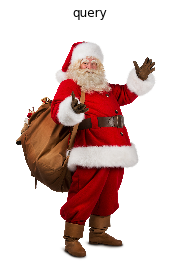

('n03888257', 'parachute', 0.350593)
('n03045698', 'cloak', 0.10991247)
('n04192698', 'shield', 0.087342106)
('n02879718', 'bow', 0.06885182)
('n02817516', 'bearskin', 0.035525296)
('n04507155', 'umbrella', 0.027239721)
('n03026506', 'Christmas_stocking', 0.018158134)
('n03617480', 'kimono', 0.01756873)
('n04525038', 'velvet', 0.015767721)
('n02895154', 'breastplate', 0.014047553)



In [60]:
# Predict an image
scale = 1.0
filename = "google_images/000046.jpg"
plt.figure(figsize=(20, 10))

#showimg(filename, "query", i+1, scale)
imgs = showpartimg(filename, "query", 1, 1, scale)
plt.show()

for img in imgs:
    reslist = predictpart(filename, 10, scale)
    for results in reslist:
        for result in results:
            print(result)
    print()

In [0]:
import math
import binascii
from datetime import datetime

def createindex(indexname):
    if es.indices.exists(index=indexname):
        es.indices.delete(index=indexname)
    es.indices.create(index=indexname,  body={
        "settings": {
            "index.mapping.total_fields.limit": 10000,
        }
    })

    mapping = {
        "image": {
            "properties": {
                "f": {
                    "type": "text"
                },
                's': {
                    "type": "sparse_vector"
                }
            }
        }
    }
    es.indices.put_mapping(index=indexname, doc_type='image', body=mapping, include_type_name=True)

wnidmap = {}

def loadimages(directory):
    imagefiles = []
    for file in os.listdir(directory):
        if file.rfind('.jpg') < 0:
            continue
        filepath = os.path.join(directory, file)
        imagefiles.append(filepath)
    return imagefiles

def indexfiles(indexname, directory, featuresize=10, docsize=1000):
    imagefiles = loadimages(directory)
    for i in range(len(imagefiles)):
        if i >= docsize:
            return
        filename = imagefiles[i]
        indexfile(indexname, filename, i, featuresize)
        sys.stdout.write("\r%d" % (i + 1))
        sys.stdout.flush()
    es.indices.refresh(index=indexname)    

def indexfile(indexname, filename, i, featuresize):
    global wnidmap

    rounddown = 16
    doc = {'f': filename, 's':{}}
    results = predict(filename, featuresize) 

    #print(len(results))
    synset = doc['s']
    for result in results:
        score = float(str(result[2]))
        wnid = result[0]
        id = 0
        if wnid in wnidmap.keys():
            id = wnidmap[wnid]
        else:
            id = len(wnidmap)
            wnidmap[wnid] = id
        synset[str(id)] = score

    #print(doc)
    #count = es.count(index=indexname, doc_type='image')['count']
    count = i
    res = es.index(index=indexname, doc_type='image', id=count, body=doc)

In [0]:
createindex("santa-search")

directory = "google_images/"
indexfiles("santa-search", directory, 100, 1000)
#directory = "bing_images/"
#indexfiles("santa-search", directory, 100, 1000)
#directory = "baidu_images/"
#indexfiles("santa-search", directory, 100, 1000)

In [99]:
res = es.search(index="santa-search", request_timeout=60, body={"query": {"match_all": {}}})
print("Got " + str(res['hits']['total']) + " Hits:" )
for hit in res['hits']['hits']:
    print(hit["_source"])
    #print("%(timestamp)s %(author)s: %(text)s" % hit["_source"])

2019-12-28 12:24:41,606 - INFO - elasticsearch - GET http://localhost:9200/santa-search/_search [status:200 request:0.013s]


Got {'value': 5, 'relation': 'eq'} Hits:
{'f': 'google_images/000639.jpg', 's': {'0': 0.09703259, '1': 0.07990838, '2': 0.07638594, '3': 0.070676304, '4': 0.060715247}}
{'f': 'google_images/000046.jpg', 's': {'9': 0.350593, '7': 0.10991247, '3': 0.087342106, '10': 0.06885182, '11': 0.035525296}}
{'f': 'google_images/000055.jpg', 's': {'17': 0.1328183, '18': 0.12914655, '19': 0.07873232, '8': 0.06275505, '20': 0.059591345}}
{'f': 'google_images/000338.jpg', 's': {'1': 0.1897988, '29': 0.12868801, '30': 0.11154004, '31': 0.089490764, '22': 0.058901202}}
{'f': 'google_images/000420.jpg', 's': {'36': 0.3944402, '31': 0.10916335, '37': 0.062429387, '38': 0.026450532, '39': 0.026012763}}


In [0]:
def searchimg(indexname, filename, num=10, topk=10, scoretype='dot', scale=1.0, partition=1):
    plt.figure(figsize=(20, 10))
    
    imgs = showpartimg(filename, "query", 1, partition, scale)
    plt.show()

    reslist = []
    for img in imgs:
        results = predictimg(img, num, scale)
        for result in results:
            print(result)
        print()
        res = search(indexname, results, num, topk, scoretype)
        reslist.append(res)
    return reslist

def search(indexname, synsets, num, topk, scoretype='dot', disp=True):
    if scoretype == 'vcos':
        inline = {}
        for synset in synsets:
            score = synset[2]
            if score <= 0.0:
                continue
            wnid = synset[0]
            if wnid not in wnidmap.keys():
                continue
            id = wnidmap[wnid]
            inline[str(id)] = float(score)
        if inline == {}: 
            print("Got " +  str(0) + " Hits:")
            return
        #print('wnidmap = ' + str(wnidmap))
        #print('inline = ' + str(inline))

        b = {
            "size": topk,
            "query": {
              "script_score": {
                "query": {"match_all": {}}, 
                "script": {
                  "source": "cosineSimilaritySparse(params.s, doc['s']) + 0.01", 
                  "params": {
                      's': {}
                  }
                }
              }
        }}
        b['query']['script_score']['script']['params']['s'] = inline
        res = es.search(index=indexname, body=b)
        print(str(b))

        if disp==True:
            print("Got " +  str(res['hits']['total']['value']) + " Hits:")
            topres = res['hits']['hits'][0:topk]
            for hit in topres:
                print(str(hit["_id"]) + " " + str(hit["_source"]["f"]) + " "  + str(hit["_score"]))
            plt.figure(figsize=(20, 10))

            for i in range(len(topres)):
                hit = topres[i]
                row = 5
                col = int(topk / 5)
                if i >= 25:
                    break
                showimg(hit["_source"]["f"], hit["_id"], i+1, col, row)
            plt.show()
        
        return res


2 5 1


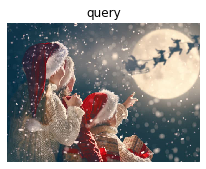

2019-12-28 13:27:47,510 - INFO - elasticsearch - GET http://localhost:9200/santa-search/_search [status:200 request:0.126s]


('n01910747', 'jellyfish', 0.9188104)
('n09229709', 'bubble', 0.04519146)
('n01443537', 'goldfish', 0.0053428826)
('n03388043', 'fountain', 0.0052984403)
('n04296562', 'stage', 0.0027624022)
('n01664065', 'loggerhead', 0.0017735192)
('n02134084', 'ice_bear', 0.0014510605)
('n01950731', 'sea_slug', 0.0013744229)
('n01484850', 'great_white_shark', 0.00090591353)
('n01860187', 'black_swan', 0.00083802926)

{'size': 10, 'query': {'script_score': {'query': {'match_all': {}}, 'script': {'source': "cosineSimilaritySparse(params.s, doc['s']) + 0.01", 'params': {'s': {'575': 0.9188104271888733, '258': 0.045191459357738495, '382': 0.005342882592231035, '9': 0.005298440344631672, '67': 0.0027624021749943495, '919': 0.0017735192086547613, '543': 0.0014510605251416564, '501': 0.0013744229217991233, '348': 0.0009059135336428881, '378': 0.0008380292565561831}}}}}}
Got 526 Hits:
427 google_images/000001.jpg 1.0099978
367 google_images/000529.jpg 0.5003607
28 google_images/000215.jpg 0.39084128
205 goo

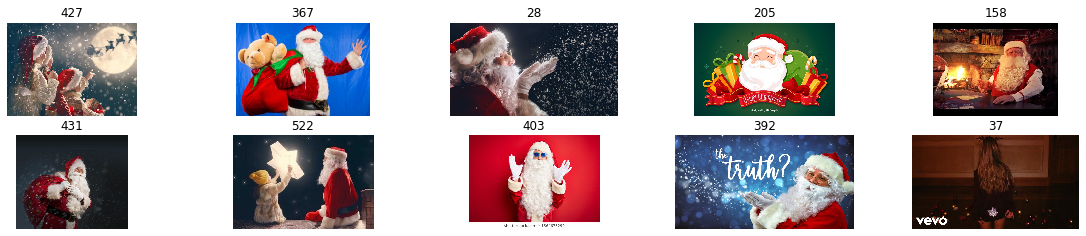

In [142]:
disp = True
filename = "google_images/000001.jpg"
_ = searchimg('santa-search', filename, 10, 10, 'vcos', 1.0, 1)